

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [ ]:
!pip install -U torch torchvision

In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import PIL
print(PIL.PILLOW_VERSION)

7.1.2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!ls -l /content/gdrive/My\ Drive/simpsons/journey-springfield.zip

-rw------- 1 root root 546224286 Nov 23 21:32 '/content/gdrive/My Drive/simpsons/journey-springfield.zip'


In [ ]:
!unzip -q /content/gdrive/My\ Drive/simpsons/journey-springfield.zip

In [ ]:
!ls train
!ls testset

simpsons_dataset
testset


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi
torch.cuda.is_available()

Wed Feb  2 16:44:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    30W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [ ]:
from torchvision.transforms.transforms import RandomPerspective
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == 'train':
          transform = transforms.Compose([
              transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
              transforms.RandomVerticalFlip(p=0.5),
              transforms.RandomHorizontalFlip(p=0.5),  
              transforms.RandomRotation(degrees=30), 
              transforms.RandomPerspective(p=0.3),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
        else:
          transform = transforms.Compose([ 
              transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
        x = self.load_sample(self.files[index])
      #  x = self._prepare_sample(x)
      #  x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
  #  def _prepare_sample(self, image):
   #     image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    #    return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels)

train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

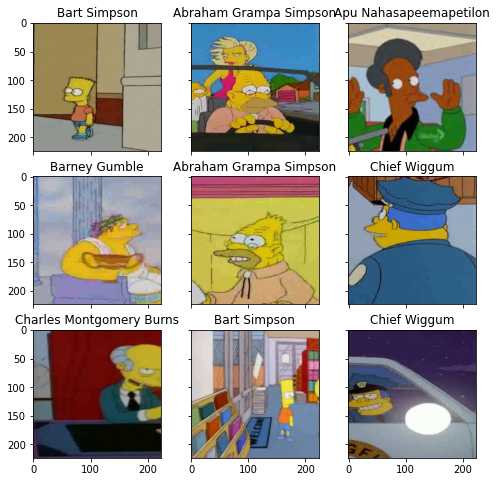

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

In [ ]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons


def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")


def create_dct_from_labels(train_val_labels):
    """Функция создает из list train_val_labels, содержащего метки классов
    соответсвующим картинкам из выборки, словарь dict с ключами соответсвующими
    названиям классов, и значениями, соответвующими колчеству этих классов в 
    list train_val_labels"""
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons.update({label_i:train_val_labels.count(label_i)})

    return dct_simpsons

In [ ]:
# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_labels)

In [ ]:
# Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

In [ ]:
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files] # классы train

# выведем на печать класс:количесвто картинок для train должно быть примерно 75 %
print_dct(create_dct_from_labels(new_train_label))

abraham_grampa_simpson	730
agnes_skinner	100
apu_nahasapeemapetilon	498
barney_gumble	100
bart_simpson	1074
carl_carlson	100
charles_montgomery_burns	954
chief_wiggum	789
cletus_spuckler	100
comic_book_guy	375
disco_stu	100
edna_krabappel	366
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1797
kent_brockman	398
krusty_the_clown	965
lenny_leonard	248
lionel_hutz	100
lisa_simpson	1083
maggie_simpson	102
marge_simpson	1033
martin_prince	100
mayor_quimby	197
milhouse_van_houten	863
miss_hoover	100
moe_szyslak	1161
ned_flanders	1163
nelson_muntz	286
otto_mann	100
patty_bouvier	100
principal_skinner	955
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	702
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	145


### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(8),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(96),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=96*5*5, out_features=4800),
            nn.ReLU(),
            nn.BatchNorm1d(4800), 
            nn.Dropout(p=0.2),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4800, out_features=2400),
            nn.ReLU(),
        )
        self.out = nn.Linear(2400, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

        del inputs
        del labels
        del outputs
        del preds
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

        del inputs
        del labels
        del outputs
        del preds

    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr = 1e-4)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
print("we will classify :{}".format(n_classes))

we will classify :42


In [ ]:
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, paddi

Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
new_train_dataset = SimpsonsDataset(new_train_files, mode = 'train')

# train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
#                                           stratify=train_val_labels)

# train_labels = [path.parent.name for path in train_files] # классы train
# val_labels = [path.parent.name for path in val_files]     # классы val

In [ ]:
history = train(new_train_dataset, val_dataset, model=simple_cnn, epochs=25, batch_size=256)

epoch:   0%|          | 0/25 [00:04<?, ?it/s]


KeyboardInterrupt: ignored

Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

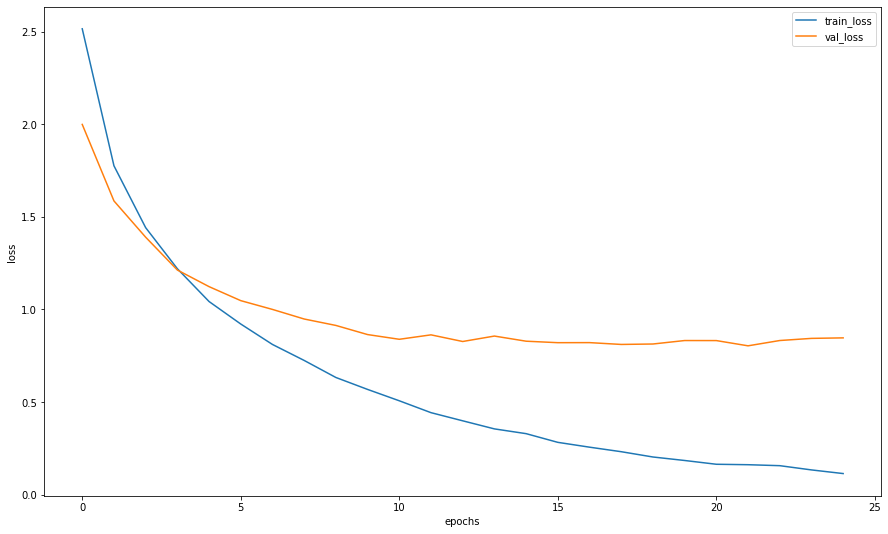

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

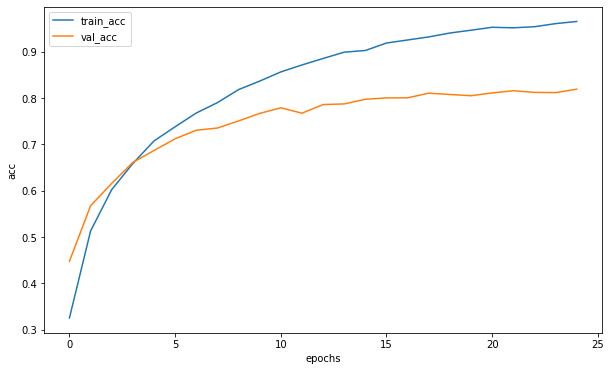

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [74]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_effb0, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_effb0, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')


0.9500000000000001

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

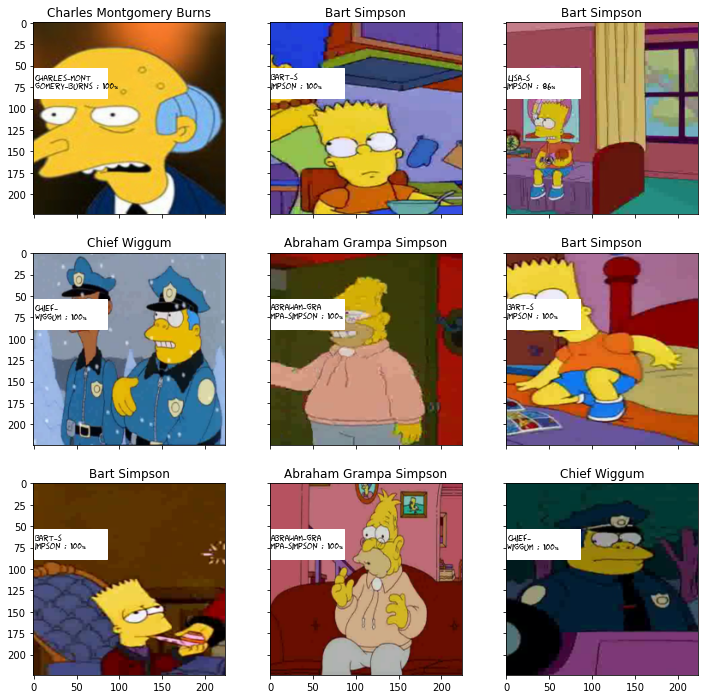

In [164]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_effb0, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [165]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_effb0, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [166]:
! ls 

characters_illustration.png  label_encoder.pkl	sample_submission.csv  testset
gdrive			     sample_data	sub.csv		       train


In [167]:
import pandas as pd
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# import pandas as pd
# df = pd.DataFrame()
# df['Id'] = test_filenames
# df['Expected'] = preds
# df.to_csv(Path('./submission.csv'), index=False)

In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [168]:
my_submit.to_csv('sub.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Wed Feb  2 17:01:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    30W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#next_try

In [ ]:
from torchvision import models

In [ ]:
model_effb0 = models.efficientnet_b0(pretrained=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [ ]:
model_al = models.alexnet(pretrained=True)
model_al.cuda()

In [ ]:
#layers_to_unfreeze = 6

# Выключаем подсчет градиентов для слоев, которые не будем обучать
#for param in model_al.features[:-layers_to_unfreeze].parameters():
 #   param.requires_grad = False
    
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 1280
# Заменяем Fully-Connected слой на наш линейный классификатор
model_effb0.classifier = nn.Sequential(
          nn.Dropout(p=0.3, inplace=False),
          nn.Linear(in_features=1280, out_features=512, bias=True),
          nn.ReLU(inplace=True),
          nn.Dropout(p=0.3, inplace=False),
          nn.Linear(in_features=512, out_features=256, bias=True),
          nn.ReLU(inplace=True),
          nn.Linear(in_features=256, out_features=n_classes, bias=True),
  )

In [ ]:
model_effb0.to(DEVICE)

In [ ]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels)

train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')
    
new_train_dataset = SimpsonsDataset(new_train_files, mode='train')

In [ ]:
def train1(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(params=[
        {"params": model.classifier.parameters()},
        {"params": model.features.parameters(), "lr": 1e-5,}], lr=1e-4)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [97]:
history = train1(new_train_dataset, val_dataset, model=model_effb0, epochs=1, batch_size=80)    

epoch:   0%|          | 0/1 [00:00<?, ?it/s]

loss 0.19987348654917544


epoch: 100%|██████████| 1/1 [06:18<00:00, 378.13s/it]


Epoch 001 train_loss: 0.1999     val_loss 0.1859 train_acc 0.9444 val_acc 0.9479


In [98]:
loss, acc, val_loss, val_acc = zip(*history)       

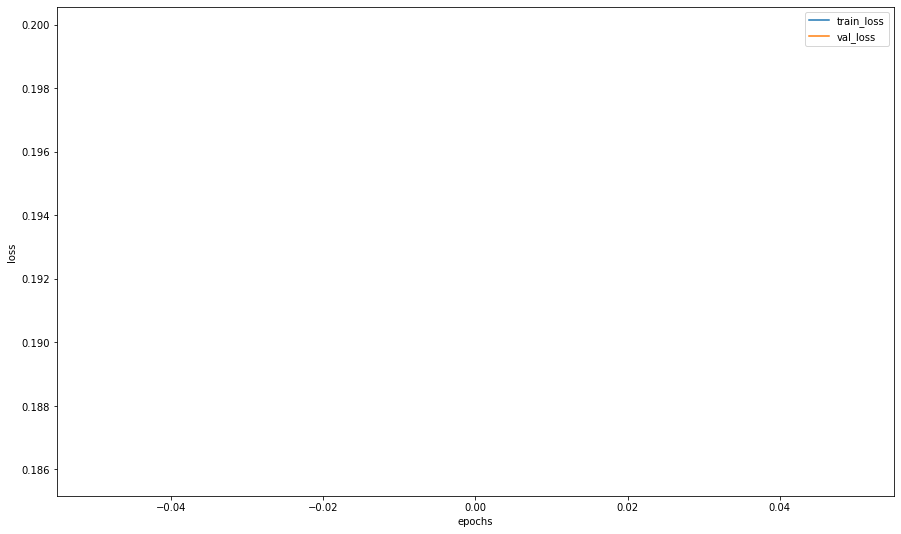

In [99]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

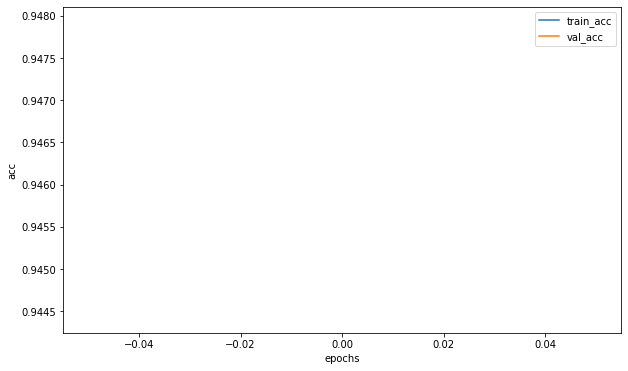

In [100]:
plt.figure(figsize=(10, 6))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [155]:
torch.cuda.empty_cache()

In [156]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_effb0, ex_img.unsqueeze(0))

In [157]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_effb0, imgs)

In [158]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [159]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [160]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')


1.0

In [ ]:
скор - 0.97236